In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

### Flow_clean file

In [2]:
# local network
#flow_clean = pd.read_csv(r"H:\R&D\Research\Commerce local\Data Analytics\Flux piétons\AFP WTS Tableau report\Data\last_wts_flow_cleaned.csv", sep=",")
#df = pd.read_csv(r"H:\R&D\Research\Commerce local\Data Analytics\Flux piétons\AFP WTS Tableau report\Data\last_wts_flow_cleaned.csv", sep=",")
# Check the number of zones 
#df.zone_id.nunique()

In [3]:
#last_wts_flow_cleaned.csv
flow_clean = pd.read_csv(r"C:\Users\hub_stag6\Documents\Data\last_wts_flow_cleaned.csv", sep=",")
flow_clean.shape

(216795, 10)

In [4]:
# Sort DataFrame
flow_clean = flow_clean.sort_values(by=['zone_id', 'Date_jour_heure'], ascending=True)
# Split the 'Date' variable 
flow_clean[['date', 'time']] = flow_clean.Date_jour_heure.str.split(" ", expand = True)
# Convert Date to DataTime variable
flow_clean['date'] =  pd.to_datetime(flow_clean['date'], format="%d-%m-%y")
# Create the year variable
flow_clean['year'] = flow_clean.date.dt.year

### Plot number the sensors 

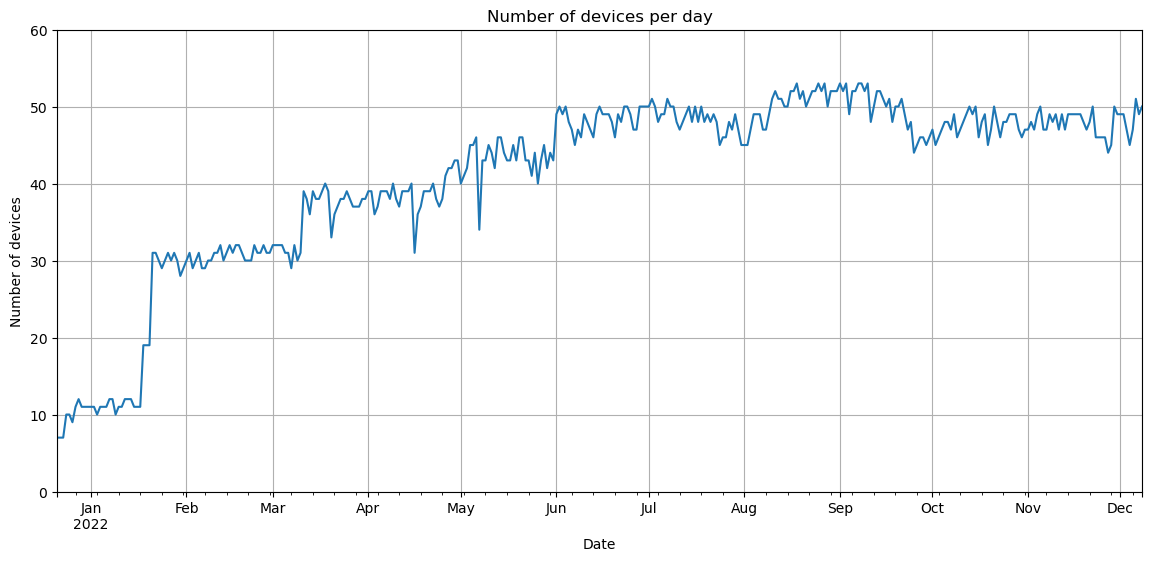

In [5]:
# Plot number of sensors
x = flow_clean.groupby('date')['zone_id'].nunique()
ax = x.plot(x='date', kind='line', figsize=(14,6), grid = True)	

ax.set_xlabel('Date')
ax.set_ylim(0, 60)
ax.set_ylabel('Number of devices')
ax.set_title('Number of devices per day')
#ax.legend(loc="upper right")
plt.show()

Drop year 2021 and January 2022

In [6]:
# Drop December 2021 and January 2022 
index = flow_clean.index[((flow_clean['year'] != 2022) | (flow_clean['Mois'] != 'January')) & (flow_clean['year'] != 2021) ].tolist()
flow_clean = flow_clean.loc[index, : ].reset_index(drop=True)
flow_clean.shape


(206550, 13)

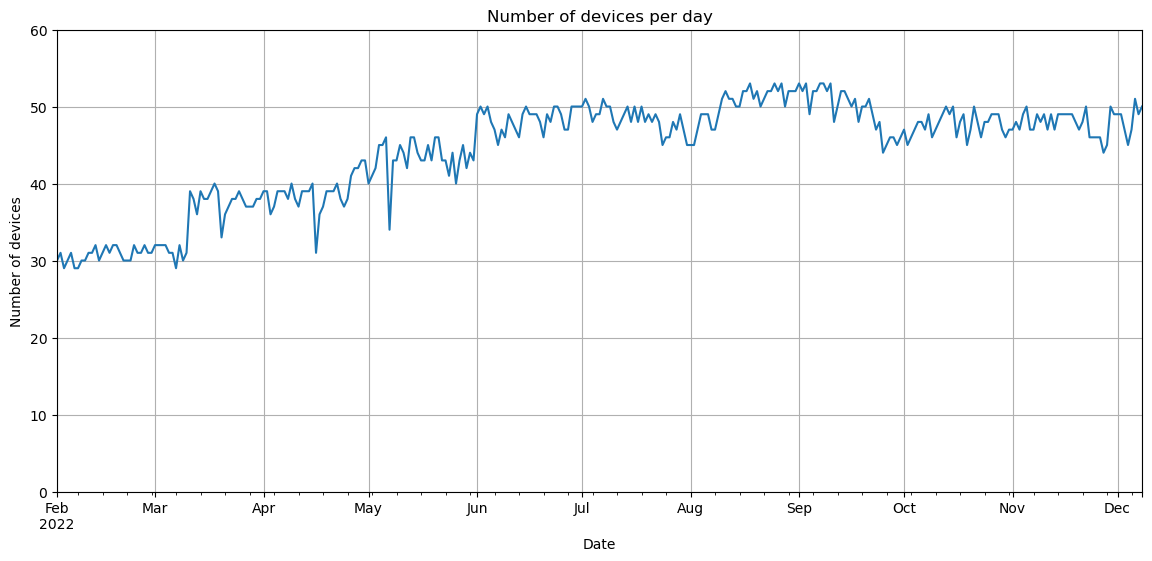

In [7]:
# Plot number of sensors
x = flow_clean.groupby('date')['zone_id'].nunique()
ax = x.plot(x='date', kind='line', figsize=(14,6), grid = True)	

ax.set_xlabel('Date')
ax.set_ylim(0, 60)
ax.set_ylabel('Number of devices')
ax.set_title('Number of devices per day')
#ax.legend(loc="upper right")
plt.show()

In [8]:
# DataFrame without Hours variable 
df = flow_clean.loc[:,['zone_id', 'date', 'year', 'Mois', 'Jour_semaine', 'Somme par jour']]
df.drop_duplicates(inplace=True, ignore_index=True)
df.shape


(13770, 6)

In [9]:
df.zone_id.nunique()

67

### Join with zones

In [10]:
# Read the file
zones = pd.read_csv('./assets/zones_modif.csv')
zones = zones.drop(['Unnamed: 0'], axis=1)
zones.shape

(62, 11)

In [11]:
# Join
join_df=pd.merge(df, zones, on='zone_id', how='left')
join_df.shape

(13770, 16)

### Join with weather 

In [12]:
# Read the file
weather = pd.read_csv('./assets/weather_daily.csv')
weather = weather.drop(['Unnamed: 0'], axis=1)
# Convert Date to DataTime variable
weather['date'] =  pd.to_datetime(weather['date'], format="%Y-%m-%d")

In [13]:
join_df=pd.merge(join_df, weather, on='date', how='left')
#join_df.info()

### Join DataSet File

Join Flow_clean file:
- without December 2021 and January 2022
- without hours  

Weather:  
- per day

In [14]:
join_df.to_csv('./assets/joinDataset.csv')

## Join Dataset with hours for the Model

In [15]:
# Join with zones
join_df2=pd.merge(flow_clean, zones, on='zone_id', how='left')
# Join with weather
join_df2=pd.merge(join_df2, weather, on='date', how='left')
join_df2.shape

(206550, 35)

### Create a 'day_part' variable

In [16]:
#day_part function
def day_part(Heure):
    if Heure in [7,8,9,10,11]:
        return "morning"
    elif Heure in [12,13,14,15,16]:
        return "afternoon"
    elif Heure in [17,18,19,20,21]:
        return "evening"
    
#Run function with apply method
join_df2['day_part'] = join_df2['Heure'].apply(day_part)
#join_df2.tail()

In [17]:
## calculate the sum of visitors per part of the day
join_df2["Sum_part_day"]=join_df2.groupby(['zone_id','date','day_part']).visit.transform('sum')

In [18]:
join_df2.columns

Index(['zone_id', 'id_zone_jour', 'Date_jour_heure', 'Mois', 'Jour_semaine',
       'Date_jour', 'Heure', 'visit', 'Somme par jour', 'Comptage mois',
       'date', 'time', 'year', 'nom_capteur', 'Quartier', 'shop',
       'id _capteur_quartier', 'type_capteur', 'address', 'zipcode', 'city',
       'longitude', 'latitude', 'weather_date', 'main', 'temperature',
       'temperaturefeelslike', 'temperaturemin', 'temperaturemax', 'pressure',
       'humidity', 'visibility', 'windspeed', 'rain', 'snow', 'day_part',
       'Sum_part_day'],
      dtype='object')

In [19]:
# Select columns 
df = join_df2.loc[:,['zone_id', 'Quartier', 'shop','date', 'type_capteur', 'year', 'Mois', 'Jour_semaine', 'day_part', 'Somme par jour', 'Sum_part_day']] #'avg_visitors_perDay'
# Sort DataFrame
df.sort_values(by=['zone_id', 'date'])
# Drop duplicates
df.drop_duplicates(inplace=True, ignore_index=True)
df.tail(4)

,zone_id,Quartier,shop,date,type_capteur,year,Mois,Jour_semaine,day_part,Somme par jour,Sum_part_day
41306,13757,NaN,NaN,2022-12-07,NaN,2022,December,Wednesday,evening,16202,4871
41307,13757,NaN,NaN,2022-12-08,NaN,2022,December,Thursday,morning,15498,3365
41308,13757,NaN,NaN,2022-12-08,NaN,2022,December,Thursday,afternoon,15498,7836
41309,13757,NaN,NaN,2022-12-08,NaN,2022,December,Thursday,evening,15498,4297


In [20]:
# Remove temporary sensors 
df = df[df['type_capteur'] != 'temporaire']
df.reset_index(drop=True, inplace=True)
df['type_capteur'].value_counts()

fixe    38703
Name: type_capteur, dtype: int64

### DataSet for model File
Only fixed sensors

In [21]:
df.to_csv('./assets/Dataset_model.csv')
